# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as gaussian

# Data Preprocessing

In [2]:
data = pd.read_csv('multigauss.txt', sep = " ", header = None)

In [3]:
data.head()

,0,1,2
0,#,name:,XX
1,#,type:,matrix
2,#,rows:,1250
3,#,columns:,2
4,NaN,1.343973435284349,0.1511043422294572


In [4]:
#Drop the redundant rows and columns
data.drop(0, axis = 1, inplace = True)
data.drop([0, 1, 2, 3], axis = 0, inplace = True)

In [5]:
data.head()

,1,2
4,1.343973435284349,0.1511043422294572
5,0.9626717660160129,0.3827812289862362
6,0.5023257633515988,-0.1813927047883676
7,0.3677464033583122,0.804004582610822
8,-0.8079136978717317,0.2692090961704308


In [6]:
#converting datatype from Object to Float64
data = data.astype('float64')

In [7]:
#checking for null values
data.isna().sum()

1    0
2    0
dtype: int64

# Modelling

In [8]:
#Built using oop
class EM():
    def __init__(self):
        #initialize the params and set them all to None
        self.k = None
        self.mean = None
        self.std = None
        self.pi = None
        self.mu = None
        self.cov = None
        self.ll = None
        
    def fit(self, X, K, random_state = 42, t = 1e-5):
        # t is the threshold value
        # If the difference between the old params and new params is lesser than t, then training will stop
        self.k = K
        #normalize the data
        self.mean = X.mean()
        self.std = X.std()
        X = (X - self.mean) / self.std
        n, f = X.shape
        #initialize params according to their corresponding shapes
        r = np.random.default_rng(random_state)
        w = np.zeros((n, self.k))
        self.pi = r.random((self.k, 1))
        self.mu = r.random((self.k, f))
        self.cov = np.array([np.identity(f)] * self.k)
        self.ll = []
        pi = self.pi.copy()
        mu = self.mu.copy()
        cov = self.cov.copy()
        
        while True:
            #E step
            #calculate weights
            for k in range(self.k):
                gauss = gaussian.pdf(X.values, self.mu[k], self.cov[k]) #get the nultivariate gaussian values using X, mu and cov
                w[:, k] = self.pi[k] * gauss
            
            #calculate the log likelihood values
            self.ll.append(np.sum(np.log(np.sum(w, axis = 1))))
            wSum = np.sum(w, axis = 1, keepdims = True)
            w /= wSum
            Nk = np.sum(w, axis = 0, keepdims = True).T
            
            #M step
            #get params from weights
            self.pi = Nk / n
            self.mu = np.dot(w.T, X.values) / Nk
            for k in range(self.k):
                diff = X.values - self.mu[k]
                self.cov[k] = np.matmul((w[:, k] * diff.T), diff) / Nk[k]
            
            #breaking condition
            if (np.all((abs(pi - self.pi) < t) == True) 
            and np.all((abs(mu - self.mu) < t) == True) 
            and np.all((abs(cov - self.cov) < t) == True)):
                break
            
            #update params
            pi = self.pi.copy()
            mu = self.mu.copy()
            cov = self.cov.copy()
            
    def predict(self, X):
        #assign clusters to the data using the calculated params
        w = []
        for k in range(self.k):
            w.append(gaussian.pdf(X, self.mu[k], self.cov[k]))
        w = np.array(w)
        return np.argmax(w, axis = 0)

# Training the model

In [9]:
em = EM()
em.fit(data, 5)

# Assigning clusters

In [10]:
em.predict(data)

array([0, 0, 3, ..., 4, 4, 4], dtype=int64)

# Plotting the log likelihood graph

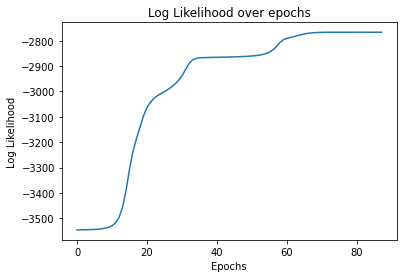

In [11]:
plt.title("Log Likelihood over epochs")
plt.plot(range(len(em.ll) - 1), em.ll[1:])
plt.xlabel("Epochs")
plt.ylabel("Log Likelihood")
plt.show()